In [1]:
import os
os.chdir('../')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import anndata as ad
import pandas as pd

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0
/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(12, 3))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

In [4]:
condition_key = 'batch'
cell_type_key = 'final_annotation'
target_conditions = ['10X']

surgery_path = 'surgery_model'
output = 'Immune_ALL_human.h5ad'

In [5]:
adata_all = sc.read(output)

source_adata = adata_all[~adata_all.obs[condition_key].isin(target_conditions)].copy()
target_adata = adata_all[adata_all.obs[condition_key].isin(target_conditions)].copy()

In [6]:
model = sca.models.SCVI.load(surgery_path, adata_all)

INFO     File surgery_model/model.pt already downloaded                                                            


In [7]:
adata_ref_latent = sc.AnnData(model.get_latent_representation(adata=source_adata))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [8]:
adata_query_latent = sc.AnnData(model.get_latent_representation(adata=target_adata))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


In [9]:
adata_all_latent =sc.AnnData(model.get_latent_representation(adata=adata_all))
adata_all_latent.obs['cell_type'] = adata_all.obs[cell_type_key].tolist()
adata_all_latent.obs['batch'] = adata_all.obs[condition_key].tolist()

In [10]:
combined_emb = ad.concat([source_adata, adata_query_latent], index_unique=None)

### KNN Classification
Disease-healthy cells approach: For each cell in the query
dataset, we extract its k nearest neighbors in the reference and the corresponding Euclidean
distances, adjusted by a Gaussian kernel. We compute the probability of assigning 𝑃(𝑦|𝑐)
each label to the query cell by normalising across all adjusted distances. The label 𝑦 𝑐
uncertainty corresponds to 1 − 𝑚𝑎𝑥_𝑦 (𝑃(𝑦|𝑐))

Steps:
1. Get all the distances
2. Extract for each cell in the QUERY the k nearest neighbors in the REFERENCE
3. Compute prob of assigning each label to the query cell by normalising across all adjusted distances
   
   3.1. Normalize
   
    3.2 Compute prob
4. Choose the best prob => uncert is 1 - best prob

In [11]:
# uncertainties["uncertainty"].plot(kind='box')
#TODO: Group by batch and cell type and do multiple diagrams

In [12]:
trainer = sca.utils.weighted_knn_trainer(
    adata_ref_latent,
    "X",
    n_neighbors = 15
)

_, uncertainties = sca.utils.weighted_knn_transfer(
    adata_query_latent,
    "X",
    adata_ref_latent.obs,
    "cell_type",
    trainer
)

Weighted KNN with n_neighbors = 15 ... finished!


In [13]:
uncertainties["uncertainty"] = uncertainties["cell_type"]
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

In [14]:
uncertainties

,cell_type,uncertainty,batch
0,CD4+ T cells,0.066741,10X
1,Monocyte-derived dendritic cells,0.266628,10X
2,CD14+ Monocytes,0.0,10X
3,NK cells,0.200034,10X
4,CD20+ B cells,0.066671,10X
...,...,...,...
10722,CD4+ T cells,0.0,10X
10723,CD14+ Monocytes,0.0,10X
10724,NKT cells,0.333428,10X
10725,CD4+ T cells,0.0,10X


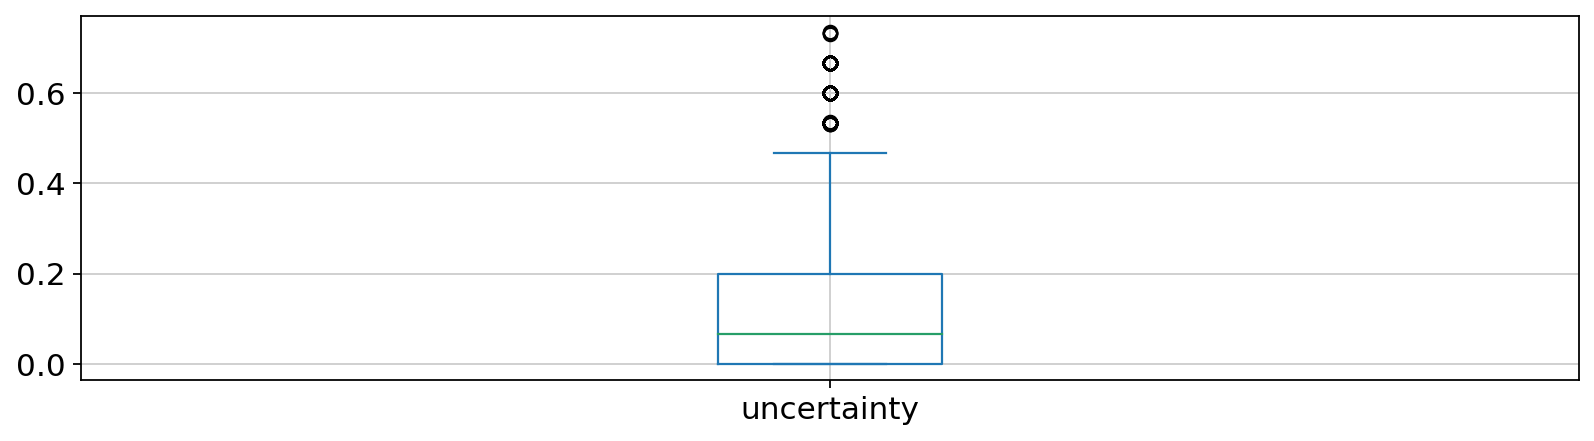

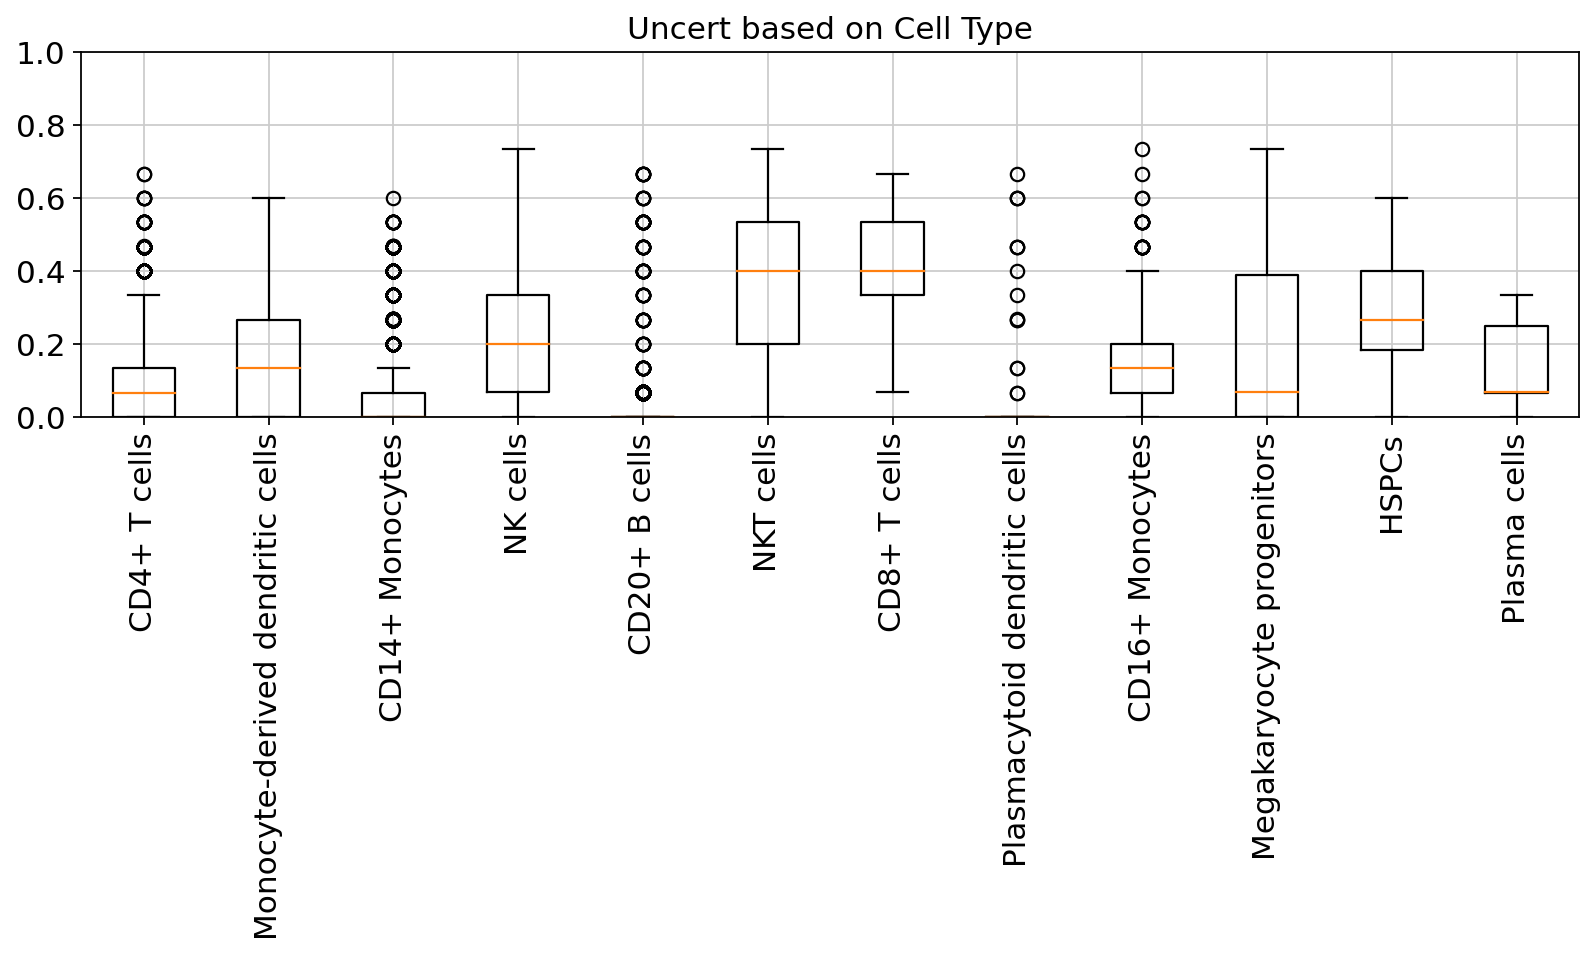

In [15]:
import matplotlib.pyplot as plt
import numpy as np

data = []
uncertainties["uncertainty"].plot(kind='box')
labels = uncertainties["cell_type"].unique()
for cell_type in labels:
  pl = uncertainties[uncertainties["cell_type"] == cell_type]["uncertainty"]
  data.append(pl)

fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Uncert based on Cell Type')
ax.set_ylim(ymin=0, ymax = 1)
plt.show()

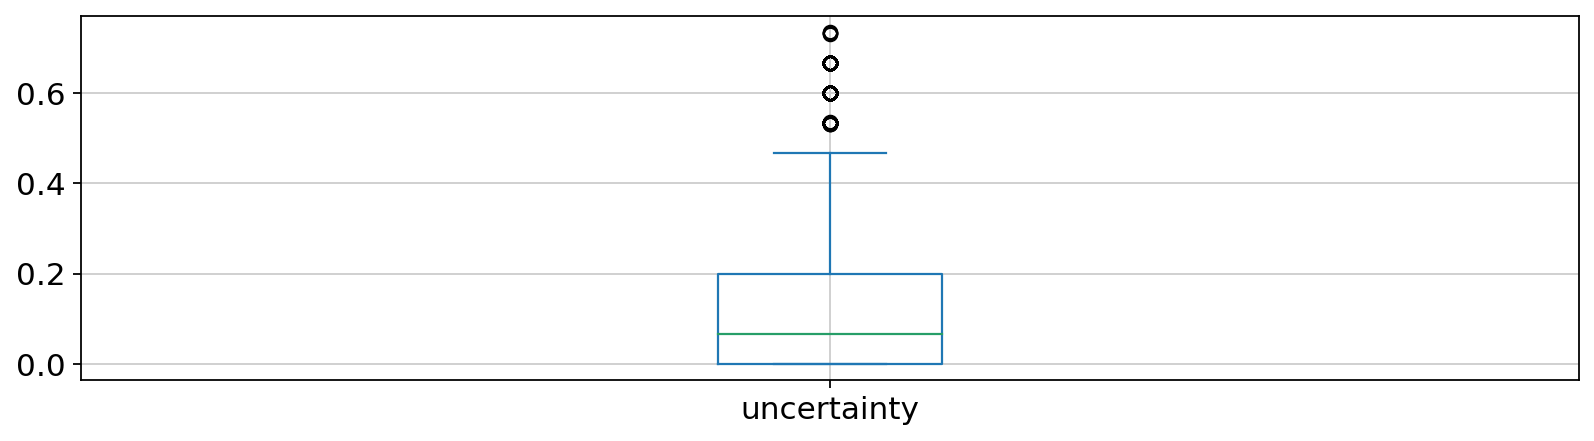

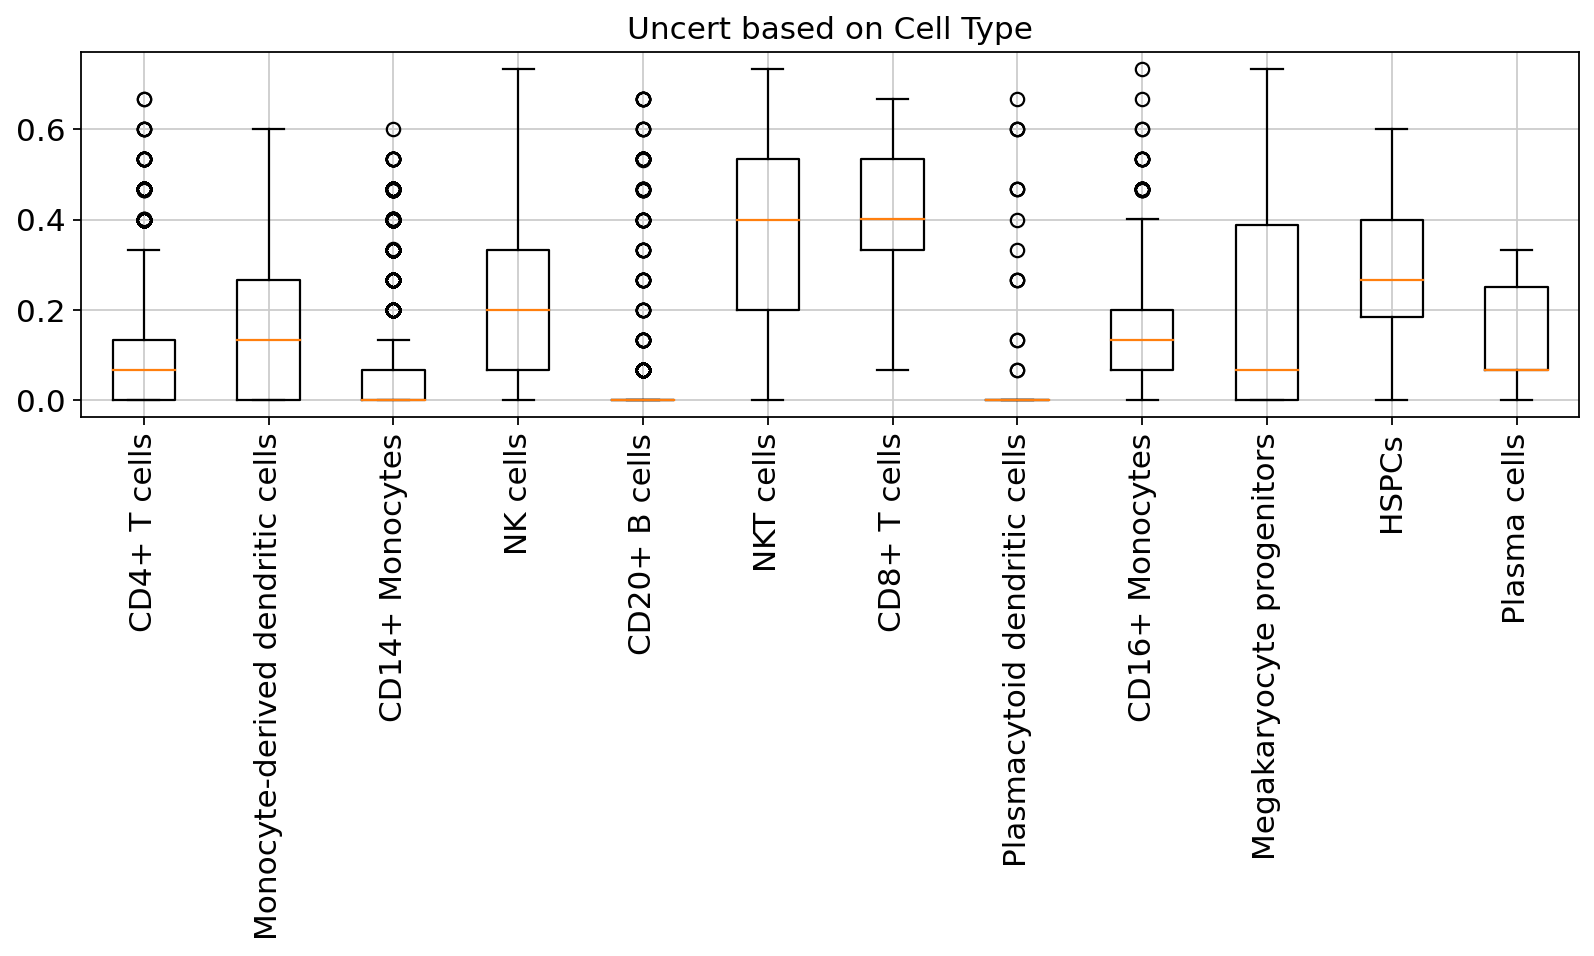

In [16]:
import matplotlib.pyplot as plt
import numpy as np

data = []
uncertainties["uncertainty"].plot(kind='box')
labels = uncertainties["cell_type"].unique()
for cell_type in labels:
  pl = uncertainties[uncertainties["cell_type"] == cell_type]["uncertainty"]
  data.append(pl)

fig, ax = plt.subplots()
ax.boxplot(data)
ax.set_xticklabels(labels, rotation=90)
ax.set_title('Uncert based on Cell Type')
plt.show()